#Collaborative filtering

###Collaborative filtering looks at similarity between users instead of focusing on similarity of content like content based filtering
###For example:2 users have given similar ratings to a few movies,so we can recommend movies rated highly by one person to another

##Importing libraries and a loading the dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install surprise
#Surprise is a library with tools like singular-value decomposition,KNN for recommender systems
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNBaseline
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
#Enter the appropriate file path for the datasets
movies=pd.read_csv("/content/drive/MyDrive/movies_data/tmdb_5000_movies.csv/tmdb_5000_movies.csv")
credits=pd.read_csv("/content/drive/MyDrive/movies_data/tmdb_5000_credits.csv/tmdb_5000_credits.csv")
#rename movie-id to id so as to merge both on the id
credits.rename(columns={"movie_id":"id"},inplace=True)
movies= movies.merge(credits,on='id')
relevant_cols=["id","title_x","genres","popularity","vote_average","vote_count","cast"]
movies=movies.loc[:,relevant_cols]
movies.rename(columns={"title_x":"title","vote_average":"rating"},inplace=True)
ratings=pd.read_csv("/content/drive/MyDrive/ratings_small.csv/ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Basically the ratings dataset has ratings of each user for the movies he has watched and we attempt to predict the ratings he would give to unseen movies by using singular value decomposition or KNN

In [ ]:
print("The total number of ratings is:",ratings.shape[0])

The total number of ratings is: 100004


Basically,each user has assigned ratings to movies he had watched &there is a timestamp to understand which movie was viewed first

In [ ]:
print("The number of unique viewers is:",ratings.describe().loc["max","userId"])

The number of unique viewers is: 671.0


In [ ]:
print("Average ratings per viewer:",ratings.shape[0]/ratings.describe().loc["max","userId"])

Average ratings per viewer: 149.03725782414307


###Lets visualize the number of user ratings for each movie

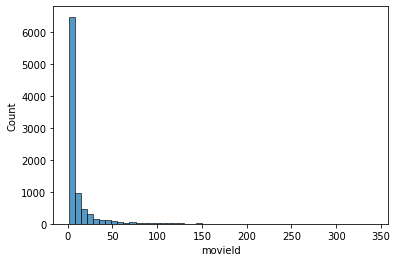

In [ ]:
sns.histplot(ratings["movieId"].value_counts(),bins=50)

First 10 movies have 6000 ratings next 10 have 1000 and thereafter there very less number of ratings which shows the movieIds ar somewhat in decreasing order of popularity

###Lets visualize the number of ratings given by each viewer

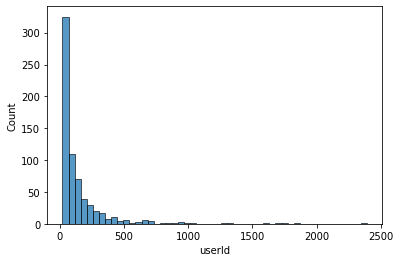

In [ ]:
#Lets visulaize the number of ratings per voter i.e. a histogram
sns.histplot(ratings.loc[:,"userId"].value_counts(),bins=50)

Most of them have watched about 100 movies & almost all have watched less 500 movies except a few outliers

Lets ignore the timestamp assuming the viewers interests don't change with time(though this maybe the case as expectations increase after watching few good movies and maybe even a decent movie was giveen a bad rating but let's ignore this aspect)

##Using the Surprise library for collaborative filtering

In [ ]:
#Create a reader object and fit it on our ratings dataset
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
#Perform SVD and KNN over the train set and test it over the test set and compare the test rmse
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

###Lets look at the test rmse of SVD v/s KNN

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.902811,4.238530,0.352616
KNNBaseline,0.905869,0.356831,3.327022


###Lets perform SVD as its test_rmse is marginally lower

In [ ]:
algo=SVD()
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'fit_time': (4.2115185260772705, 4.127397775650024, 4.175132513046265),
 'test_rmse': array([0.90389001, 0.89836509, 0.90703296]),
 'test_time': (0.24353861808776855, 0.39684605598449707, 0.24056053161621094)}

###Split the data into train and test sets and then predict the users ratings to unseen movies

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9015


0.9015469839668682

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
#Here,uid is user id,iid is movie id rui is rating ,est is estimated rating by this user to this movie
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df=df.sort_values(by='uid')

In [ ]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
3355,1,2193,2.0,2.379331,{'was_impossible': False},16,31,0.379331
6444,1,1287,2.0,3.262897,{'was_impossible': False},16,34,1.262897
2613,1,1263,2.0,3.157112,{'was_impossible': False},16,41,1.157112
19804,1,3671,3.0,3.110735,{'was_impossible': False},16,48,0.110735
2132,2,539,3.0,3.343706,{'was_impossible': False},53,90,0.343706


In [ ]:
algo.predict(1, 202, 3)

Prediction(uid=1, iid=202, r_ui=3, est=2.7248809645574545, details={'was_impossible': False})

##Get the top 10 recommendations from collaborative filtering

In [ ]:
def get_top_10_recommendations(uid):
  #Takes userId as input
  #And then recommends top 10 movies with best estimated ratings
  #Using SVD
  estimated_ratings=np.zeros(4000)
  for iid in range(4000):
    estimated_ratings[iid]=algo.predict(uid,iid)[3]
  top_indices=estimated_ratings.argsort()[-10:][::-1]
  for idx in range(10):
    print(movies.loc[top_indices[idx],'title'])

Choose the viewer id to recommend movies to

In [ ]:
id=348

Lets have a look at his recommended movies

In [ ]:
get_top_10_recommendations(id)

The Nutcracker
Serial Mom
Thinner
The Postman Always Rings Twice
Surf's Up
The Counselor
On the Line
Assassins
Basic Instinct 2
The Gunman


Most of them have watched about 100 movies & almost all have watched less 500 movies excpet a few outliers

Lets ignore the timestamp assuming the viewers interests don't change with time(though this maybe the case as expectations increase after watching few good movies and maybe even a decent movie was giveen a bad rating but let's ignore this aspect)